# Data Science Capstone Project Notebook

##  Determining the best neighbourhood in Colombo for a Restaurant



## Introduction

Colombo is the defacto (although not official) capital of Sri Lanka.
With the recent boom in tourism, it is indeed a burgeoning commercial hub, although not all areas of Colombo are the same.

Now, in this project, we imagine that we're an restauranteur  with some money to spare who wants to start a restaurant within Colombo. However, we're not sure where we should locate our restaurant. 

When deciding the location, one of the first things we should be mindful about is the number of other restaurants in the area. Of course, it would do no good to start a new restaurant right next to an existing one.

Furthermore, when considering the location for a restaurant, the number of nearby hotels and entertainment venues can have a significant effect on the patronage numbers of the restaurant. 
For example, if a person goes out to a spa to pamper themselves or to watch a movie at a Cineplex, it's highly likely that they would also visit a nearby restaurant for dinner afterwards. In the same way, guests at hotels, especially foreign tourists, are highly likely to visit a nearby restaurant to sample the cuisine.

Hence in this project, we would be attempting to cluster the neighbourhoods of Colombo based on the relative density of restaurants, hotels and entertainment venues.


## Methodology

In this project, we will obtain the neighbourhoods in Colombo by scraping the relevant Wikipedia page. Then, after cleaning the data, we will obtain the geographical coordinates of each of the neighbourhoods from Geocoders.
Next, we will use Foursquare API to obtain the nearby venues, and filter the venues to obtain the number of hotels, restaurants and entertainment venues in each of the neighbourhoods.
Then we will use K-means clustering to cluster the neighbourhoods, based on the relative density of hotels, restaurants and entertainment venues.

## 1. Initializing the project

### 1.1. Installing packages that we would be using later on in this project

In [3]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

### 2.2 Importing libraries and dependencies for the project

In [46]:
import pandas as pd

import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

import folium # map rendering library

## 2. Obtaining the neighbourhood data

We first need to get the breakdrown of the Colombo district by postal code.
This can be obtained by scraping the Wikipedia page below and extracting the information.

https://en.wikipedia.org/wiki/Postal_codes_in_Sri_Lanka

In [16]:
scraped_data=pd.read_html("https://en.wikipedia.org/wiki/Postal_codes_in_Sri_Lanka")
table=scraped_data[1]
display(table)

,Province,District,City3666,Post Code
0,Eastern,Ampara,Ampara,32000
1,Eastern,Kattankudy,Kattankudy,30100
2,Eastern,Batticaloa,Batticaloa,30000
3,North Central,Anuradhapura,Anuradhapura,50000
4,Uva,Badulla,Badulla,90001
5,Western,Colombo,Battaramulla,10120
6,Western,Colombo,Bambalapitiya,400
7,Western,Colombo,Wellawatte,600
8,Western,Colombo,Colpetty,300
9,Western,Colombo,Narahenpita,500


We then filter the data to only get only the neighbourhoods in Colombo, as well as cleaning the data to make it uniform.

In [17]:
#Filter to get only the areas in the Colombo District
df_cmb=table[table.District=='Colombo']

#Cleaning the data and removing redundant columns.
df_cmb=df_cmb[['City3666','Post Code']]
df_cmb.rename(columns={'City3666':'Neighborhood','Post Code':'Postal Code'},inplace=True)
df_cmb.set_index('Postal Code',inplace=True)
df_cmb.reset_index(inplace=True)
df_cmb['Postal Code'] = df_cmb['Postal Code'].apply('{0:0>5}'.format)

display(df_cmb)

,Postal Code,Neighborhood
0,10120,Battaramulla
1,00400,Bambalapitiya
2,00600,Wellawatte
3,00300,Colpetty
4,00500,Narahenpita
5,00800,Borella
6,00700,Cinnamon Gardens
7,00900,Dematagoda
8,00100,Fort
9,01200,Hultsdorf


A few manual edits were done retroactively here on the neighhborhood names in order to make it possible to get the location data through Geocoder.

In [18]:
#Manual edits
df_cmb['Neighborhood'].replace(to_replace='Colpetty', value='Kollupitiya',inplace=True)
df_cmb['Neighborhood'].replace(to_replace='Hultsdorf', value='Hulftsdorp',inplace=True)
df_cmb

,Postal Code,Neighborhood
0,10120,Battaramulla
1,00400,Bambalapitiya
2,00600,Wellawatte
3,00300,Kollupitiya
4,00500,Narahenpita
5,00800,Borella
6,00700,Cinnamon Gardens
7,00900,Dematagoda
8,00100,Fort
9,01200,Hulftsdorp


In [19]:
print("The dimensions of the dataframe are",df_cmb.shape)

The dimensions of the dataframe are (23, 2)


## 3.  Obtaining the location data of the neighborhoods

We now use Geocoder to obtain the latitudes and longitudes for all the neighbourhoods

In [20]:
df_cmb['Latitude']=0.0
df_cmb['Longitude']=0.0

geolocator = Nominatim(user_agent="cmb_explorer")

for i in df_cmb.index:
    address=df_cmb.at[i,'Neighborhood']+', Colombo'
    print(address)
    
    location=None
    while(location is None):
        location = geolocator.geocode(address)
        
    latitude = location.latitude
    longitude = location.longitude
    df_cmb.at[i,'Latitude']=latitude
    df_cmb.at[i,'Longitude']=longitude

Battaramulla, Colombo
Bambalapitiya, Colombo
Wellawatte, Colombo
Kollupitiya, Colombo
Narahenpita, Colombo
Borella, Colombo
Cinnamon Gardens, Colombo
Dematagoda, Colombo
Fort, Colombo
Hulftsdorp, Colombo
Kotahena, Colombo
Maradana, Colombo
Grandpass, Colombo
Mutwal, Colombo
Pettah, Colombo
Slave Island, Colombo
Sri Jayawardenepura, Colombo
Rajagiriya, Colombo
Dehiwala, Colombo
Kolonnawa, Colombo
Maharagama, Colombo
Moratuwa, Colombo
Mount Lavinia, Colombo


The neighborhoods with the latitudes and longitudes added can be seen below.

In [21]:
#Displaying the dataframe with coordinates added.
display(df_cmb)

,Postal Code,Neighborhood,Latitude,Longitude
0,10120,Battaramulla,6.902181,79.919578
1,00400,Bambalapitiya,6.901825,79.854683
2,00600,Wellawatte,6.874128,79.859332
3,00300,Kollupitiya,6.921812,79.865561
4,00500,Narahenpita,6.905727,79.882130
5,00800,Borella,6.917932,79.880256
6,00700,Cinnamon Gardens,6.910335,79.866994
7,00900,Dematagoda,6.936130,79.880049
8,00100,Fort,6.946338,79.843968
9,01200,Hulftsdorp,6.935853,79.860260


## 4.  Creating a map of Colombo with all the neighborhood centres marked

We now create a map of Colombo with the locations of the neighborhoods marked, using Folium

In [22]:
central_loc = [df_cmb.Latitude.mean(),df_cmb.Longitude.mean()]
central_loc

[6.905580743478263, 79.87497467983943]

In [23]:
# create map of Colombo using latitude and longitude values
map_cmb = folium.Map(location=[central_loc[0], central_loc[1]], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_cmb['Latitude'], df_cmb['Longitude'], df_cmb['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cmb)  
    
map_cmb

## 5.  Distance between neighborhood centres

When we look at the map above, we see that not all the neighborhoods are located at the same distance from each other. 

We calculate the distance between each of the neighborhood centres in order to gain a better understanding of the geographical distribution of the neighbourhoods

In [25]:
dist=np.zeros((df_cmb.index.size, df_cmb.index.size),dtype=float)

for p in df_cmb.index:
    for q in df_cmb.index:
        coord1=(df_cmb.at[p,'Latitude'],df_cmb.at[p,'Longitude'])
        coord2=(df_cmb.at[q,'Latitude'],df_cmb.at[q,'Longitude'])
        temp=geopy.distance.distance(coord1,coord2).km
        dist[p,q]=temp

In [26]:
#Displaying distance between neighbourhood centres as a dataframe.
df_dist=pd.DataFrame(data=dist,
                   index=df_cmb['Neighborhood'],
                 columns=df_cmb['Neighborhood'])

del df_dist.index.name
del df_dist.columns.name
display(df_dist)

,Battaramulla,Bambalapitiya,Wellawatte,Kollupitiya,Narahenpita,Borella,Cinnamon Gardens,Dematagoda,Fort,Hulftsdorp,Kotahena,Maradana,Grandpass,Mutwal,Pettah,Slave Island,Sri Jayawardenepura,Rajagiriya,Dehiwala,Kolonnawa,Maharagama,Moratuwa,Mount Lavinia
Battaramulla,0.000000,7.172127,7.345687,6.352228,4.157186,4.681824,5.880936,5.760166,9.678181,7.539251,8.468938,6.730701,6.860673,9.066788,8.172929,8.052434,1.715373,2.705731,8.172196,4.668479,6.121210,14.680245,9.585784
Bambalapitiya,7.172127,0.000000,3.105831,2.516146,3.063867,3.340729,1.654349,4.717116,5.063124,3.813312,5.236385,2.942909,5.115817,6.793111,3.577994,2.571599,7.274450,4.668171,5.727650,5.206552,9.979164,14.395606,7.747265
Wellawatte,7.345687,3.105831,0.000000,5.318158,4.308110,5.367972,4.092720,7.228974,8.164260,6.826975,8.278536,5.846519,7.888257,9.790726,6.673614,5.677009,6.711132,5.650158,2.631510,7.319515,8.006816,11.294709,4.642131
Kollupitiya,6.352228,2.516146,5.318158,0.000000,2.552958,1.679730,1.279101,2.251818,3.612588,1.659605,3.093234,0.581933,2.613333,4.506529,1.953383,1.718514,7.044420,3.651236,7.800497,2.985505,10.652038,16.379904,9.830995
Narahenpita,4.157186,3.063867,4.308110,2.552958,0.000000,1.365648,1.748671,3.370195,6.160954,4.116028,5.428011,3.082015,4.332859,6.592490,4.506341,4.096051,4.560739,1.612020,6.280501,3.109229,8.120790,14.492306,8.212681
Borella,4.681824,3.340729,5.367972,1.679730,1.365648,0.000000,1.689370,2.012616,5.094128,2.968308,4.165421,2.058383,2.971294,5.247636,3.514769,3.395908,5.479369,1.995133,7.538318,1.968735,9.343350,15.844200,9.506401
Cinnamon Gardens,5.880936,1.654349,4.092720,1.279101,1.748671,1.689370,0.000000,3.196740,4.725271,2.918515,4.366325,1.852974,3.795665,5.781856,3.058293,2.433784,6.288056,3.230986,6.532072,3.566309,9.593817,15.100857,8.559737
Dematagoda,5.760166,4.717116,7.228974,2.251818,3.370195,2.012616,3.196740,0.000000,4.143990,2.187061,2.733357,2.063487,1.116186,3.413656,3.009314,3.526678,6.940716,3.444328,9.511770,1.198815,11.091974,17.856793,11.497440
Fort,9.678181,5.063124,8.164260,3.612588,6.160954,5.094128,4.725271,4.143990,0.000000,2.141512,1.678350,3.083996,3.297666,2.851645,1.671965,2.496902,10.573087,7.066455,10.790415,5.341486,14.262927,19.457986,12.806015
Hulftsdorp,7.539251,3.813312,6.826975,1.659605,4.116028,2.968308,2.918515,2.187061,2.141512,0.000000,1.459707,1.078243,1.738301,2.980183,0.836340,1.658659,8.445373,4.927675,9.374465,3.340415,12.236114,17.994300,11.409058


From the above, we can see that there is some variance in the distances between pairs of neighbourhoods.
However when we check the distance between adjacent neighbourhoods (code below), we see that save for a few outliers, most of the neighbourhoods are within a 2km radius of each other. And even then the maximum outlier is around 6.6km.

In [27]:
for col in df_dist.columns: 
    print((col)+": Distance to closest neighbourhood: {:.2f} km".format(df_dist[col].replace(0,np.nan).min(skipna=True)))


Battaramulla: Distance to closest neighbourhood: 1.72 km
Bambalapitiya: Distance to closest neighbourhood: 1.65 km
Wellawatte: Distance to closest neighbourhood: 2.63 km
Kollupitiya: Distance to closest neighbourhood: 0.58 km
Narahenpita: Distance to closest neighbourhood: 1.37 km
Borella: Distance to closest neighbourhood: 1.37 km
Cinnamon Gardens: Distance to closest neighbourhood: 1.28 km
Dematagoda: Distance to closest neighbourhood: 1.12 km
Fort: Distance to closest neighbourhood: 1.67 km
Hulftsdorp: Distance to closest neighbourhood: 0.84 km
Kotahena: Distance to closest neighbourhood: 1.46 km
Maradana: Distance to closest neighbourhood: 0.58 km
Grandpass: Distance to closest neighbourhood: 1.12 km
Mutwal: Distance to closest neighbourhood: 1.60 km
Pettah: Distance to closest neighbourhood: 0.84 km
Slave Island: Distance to closest neighbourhood: 1.09 km
Sri Jayawardenepura: Distance to closest neighbourhood: 1.72 km
Rajagiriya: Distance to closest neighbourhood: 1.61 km
Dehiwala

## 6. Getting venue data using Foursquare API

### General Function to obtain nearby venues using Foursquare API

#### Credit: Alex Aklson and Polong Lin

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the above function, we can call the Foursquares API to obtain the venues in each of the neighbourhoods.



### Define Foursquare Credentials and Version

In [29]:
# The code was removed by Watson Studio for sharing.

### Call the function to obtain venues for the neighborhoods in Colombo

We use a search radius of 1 km for searching for the venues, since the average distance between two neighborhoods is around 2 km.
We also set a maximum limit of 100 venues per neighborhood for the search.

In [30]:
cmb_venues = getNearbyVenues(names=df_cmb['Neighborhood'],
                                   latitudes=df_cmb['Latitude'],
                                   longitudes=df_cmb['Longitude'],
                                    radius=1000,
                                 LIMIT = 100
                                  )

Battaramulla
Bambalapitiya
Wellawatte
Kollupitiya
Narahenpita
Borella
Cinnamon Gardens
Dematagoda
Fort
Hulftsdorp
Kotahena
Maradana
Grandpass
Mutwal
Pettah
Slave Island
Sri Jayawardenepura
Rajagiriya
Dehiwala
Kolonnawa
Maharagama
Moratuwa
Mount Lavinia


We just output the dataframe created from the data received from Foursquare as well as the dimensions (shape)

In [31]:
display(cmb_venues)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Battaramulla,6.902181,79.919578,Arpico Super Center,6.902215,79.917139,Department Store
1,Battaramulla,6.902181,79.919578,Il Gelato Pelawatte,6.899955,79.921299,Food
2,Battaramulla,6.902181,79.919578,Diyawannawa,6.902994,79.911839,Lake
3,Battaramulla,6.902181,79.919578,Dinemore,6.899238,79.922145,Fast Food Restaurant
4,Battaramulla,6.902181,79.919578,The Long Bar,6.906073,79.912182,Cocktail Bar
5,Battaramulla,6.902181,79.919578,McDonald's,6.903367,79.911720,Fast Food Restaurant
6,Battaramulla,6.902181,79.919578,Lavinia Bakers,6.895039,79.923853,Bakery
7,Battaramulla,6.902181,79.919578,Pranzo,6.906033,79.911777,Italian Restaurant
8,Battaramulla,6.902181,79.919578,Ginza on the Edge,6.905975,79.911615,Japanese Restaurant
9,Battaramulla,6.902181,79.919578,Pillawoos,6.902067,79.918643,Asian Restaurant


In [32]:
cmb_venues.shape

(926, 7)

We now inspect the list of unique venue categories that are present in the dataframe we just obtained. 

In [33]:
cmb_venues['Venue Category'].unique()

array(['Department Store', 'Food', 'Lake', 'Fast Food Restaurant',
       'Cocktail Bar', 'Bakery', 'Italian Restaurant',
       'Japanese Restaurant', 'Asian Restaurant', 'Chinese Restaurant',
       'Coffee Shop', 'Food Court', 'Clothing Store', 'Restaurant',
       'Food & Drink Shop', 'Garden', 'Outdoors & Recreation',
       'Indian Restaurant', 'Dessert Shop', "Men's Store", 'Hotel',
       'Café', 'IT Services', 'Thai Restaurant', 'Cupcake Shop', 'Hostel',
       'Boutique', 'Lounge', 'Seafood Restaurant',
       'Middle Eastern Restaurant', 'Optical Shop', 'Art Gallery',
       'Paper / Office Supplies Store', 'Casino', 'Jewelry Store',
       'Bed & Breakfast', 'Bubble Tea Shop', 'Office',
       'Sporting Goods Shop', 'Multiplex', 'Gastropub', 'Bookstore',
       'Sri Lankan Restaurant', 'Sandwich Place', 'Shopping Mall',
       'Grocery Store', 'Gift Shop', 'Lingerie Store', 'Theater',
       'Playground', 'Pizza Place', 'Juice Bar', 'Electronics Store',
       'American Res

Before we continue, we will group the neighbourhoods and find out what the 10 most common venues in the neighbourhood are. This is allow us to perhaps profile of the type of neighbourhood.

While we can use this to cluster the neighborhoods as well, that is not our purpose here



## 7. Grouping Neighborhoods by their most common type of venues

We will first use one-hot encoding to the venue category (which is a categorical variable) to a format we can use in our model.

In [34]:
# one hot encoding
cmb_onehot = pd.get_dummies(cmb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cmb_onehot['Neighborhood'] = cmb_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = cmb_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cmb_onehot = cmb_onehot.reindex(columns= cols)

cmb_onehot.head(30)

,Neighborhood,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beach,Beach Bar,Bed & Breakfast,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Candy Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Department Store,Dessert Shop,Diner,Dive Spot,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Garden,Garden Center,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lake,Lingerie Store,Lounge,Malay Restaurant,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Movie Theater,Multiplex,Music School,Music Venue,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pharmacy,Photography Lab,Pier,Pizza Place,Playground,Pool,Pool Hall,Pub,Racetrack,Resort,Rest Area,Restaurant,Sandwich Place,Seafood Restaurant,Shipping Store,Shopping Mall,Snack Place,Soccer Field,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Steakhouse,Supermarket,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Volleyball Court,Water Park,Women's Store
0,Battaramulla,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Battaramulla,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Battaramulla,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Battaramulla,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Battaramulla,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Battaramulla,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

We will then group the venues by neighbourhood and obtain the mean of occurrence of each type of venue.

In [35]:
cmb_grouped = cmb_onehot.groupby('Neighborhood').mean().reset_index()
cmb_grouped.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Beach,Beach Bar,Bed & Breakfast,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Candy Store,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Department Store,Dessert Shop,Diner,Dive Spot,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Garden,Garden Center,Gastropub,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lake,Lingerie Store,Lounge,Malay Restaurant,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Movie Theater,Multiplex,Music School,Music Venue,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pharmacy,Photography Lab,Pier,Pizza Place,Playground,Pool,Pool Hall,Pub,Racetrack,Resort,Rest Area,Restaurant,Sandwich Place,Seafood Restaurant,Shipping Store,Shopping Mall,Snack Place,Soccer Field,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Steakhouse,Supermarket,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Volleyball Court,Water Park,Women's Store
0,Bambalapitiya,0.0,0.0,0.01,0.0,0.02,0.00,0.030000,0.00,0.0,0.0,0.030000,0.0,0.00,0.000000,0.000000,0.01,0.0,0.0,0.0,0.030000,0.01,0.0,0.00,0.0,0.01,0.0,0.000000,0.0,0.0,0.0,0.060000,0.000000,0.02,0.050000,0.080000,0.000000,0.060000,0.000000,0.00,0.000000,0.000000,0.00,0.01,0.0,0.0,0.000000,0.040000,0.000000,0.0,0.000000,0.0,0.01,0.000000,0.030000,0.0,0.000000,0.01,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.0,0.01,0.0,0.0,0.010000,0.000000,0.00,0.00,0.0,0.0,0.0,0.02,0.000000,0.060000,0.000000,0.0,0.020000,0.00,0.010000,0.0,0.010000,0.010000,0.03,0.01,0.00,0.000000,0.01,0.01,0.000000,0.000000,0.01,0.01,0.000000,0.02,0.00,0.0,0.00,0.0,0.00,0.010000,0.01,0.00,0.000000,0.00,0.0,0.01,0.000000,0.0,0.00,0.0,0.0,0.020000,0.010000,0.0,0.0,0.00,0.0,0.0,0.0,0.030000,0.020000,0.010000,0.0,0.020000,0.0,0.00,0.0,0.00,0.02,0.00,0.00,0.02,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.03,0.010000,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,Battaramulla,0.0,0.0,0.00,0.0,0.00,0.00,0.041667,0.00,0.0,0.0,0.125000,0.0,0.00,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.083333,0.041667,0.041667,0.041667,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0,0.041667,0.041667,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.125000,0.0,0.000000,0.00,0.041667,0.041667,0.041667,0.0,0.0,0.041667,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.041667,0.0,0.041667,0.041667,0.00,0.00,0.00,0.041667,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.0,0.00,0.0,0.00,0.000000,0.00,0.00,0.041667,0.00,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.00,0.000000,0.0,0.00,0.0,0.00

Now that we have this information, we define a function find the most common venues near each neighbourhood

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]



And apply it to find the 10 most common venues in each neighbourhood

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cmb_grouped['Neighborhood']

for ind in np.arange(cmb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cmb_grouped.iloc[ind, :], num_top_venues)

display(neighborhoods_venues_sorted)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bambalapitiya,Clothing Store,Hotel,Café,Coffee Shop,Chinese Restaurant,Dessert Shop,Jewelry Store,Asian Restaurant,Thai Restaurant,Bakery
1,Battaramulla,Fast Food Restaurant,Bakery,Chinese Restaurant,Food Court,Restaurant,Garden,Food,Japanese Restaurant,Italian Restaurant,Indian Restaurant
2,Borella,Restaurant,Cosmetics Shop,Bakery,IT Services,Clothing Store,Playground,Pizza Place,Chinese Restaurant,Office,Convenience Store
3,Cinnamon Gardens,Café,Art Gallery,Coffee Shop,Restaurant,Bar,Spa,Hotel,Indian Restaurant,Theater,Pub
4,Dehiwala,Clothing Store,Cosmetics Shop,Pizza Place,Women's Store,Fast Food Restaurant,Bakery,Burger Joint,Café,Grocery Store,Chinese Restaurant
5,Dematagoda,Department Store,ATM,Supermarket,Gym,Intersection,Juice Bar,Fast Food Restaurant,Office,Cricket Ground,Convenience Store
6,Fort,Boat or Ferry,History Museum,Hotel,Donut Shop,Fondue Restaurant,Flower Shop,Flea Market,Fast Food Restaurant,Falafel Restaurant,Electronics Store
7,Grandpass,Convenience Store,Office,Athletics & Sports,Stadium,ATM,Intersection,Coffee Shop,Clothing Store,Chinese Restaurant,Cafeteria
8,Hulftsdorp,Asian Restaurant,Indian Restaurant,Jewelry Store,Vegetarian / Vegan Restaurant,Hotel,Women's Store,Office,Diner,Multiplex,Bus Station
9,Kollupitiya,Bakery,Restaurant,Café,Pharmacy,Hotel,Spa,Asian Restaurant,Japanese Restaurant,Park,Clothing Store


We see that in most of the neighborhoods, types of restaurants are the most prevalent type of venue, appearing in the top 3 in most of the neighbourhoods.

## 8. Grouping neighborhoods by hotels, restaurants and entertainment venues.

Since our focus in on the restaurants, hotels and entertainment venues, we will need to extract those venues only from the dataframe of venues.

First we need to find a way to determine whether a given venue is a restaurant or hotel or entertainment venue.
For this, we first inspect the list of unique venue categories which we obtained earlier, and identify keywords that would allow us to classify the venues into these categories.


In [38]:
keywords_ent=['Bar, Lounge','Multiplex','Recreation,''Racetrack','Gallery','Casino','Shopping Mall','Theater','Pool Hall','Performing Arts','Music Venue','Spa','Arcade','Entertainment','Park','Bowling','Golf','Pub','Stadium','Karaoke','Concert','Nightclub','Museum',]
keywords_res=['Restaurant','Snack','Noodle','Food','Dessert','Café','Diner','Buffet','Bistro','Sandwich','Pizza','Gastropub','Breakfast','BBQ','Burger','Coffee','Steak']
keywords_hot=['Hotel','Hostel','Resort']

We then use these keywords to change the values in the 'Venue Category' field to either 'Hotel', 'Restaurant' or 'Entertainment'
The venues that do not fall into any of these categories are left as they are.

In [40]:
cmb_classed=cmb_venues.copy()

#We use the keywords to replace the entries for Hotels with the term "Hotel"
cmb_classed.loc[cmb_classed['Venue Category'].str.contains('|'.join(keywords_hot)) & ~cmb_classed['Venue Category'].str.contains('Bar|Pool|Restaurant'), 'Venue Category'] = 'Hotel'

#We use the keywords to replace the entries for restaurants with the term "Restaurant"
cmb_classed.loc[cmb_classed['Venue Category'].str.contains('|'.join(keywords_res)), 'Venue Category'] = 'Restaurant'


#We use the keywords to replace the entries for entertainment establishments with the term "Entertainment"
cmb_classed.loc[cmb_classed['Venue Category'].str.contains('|'.join(keywords_ent)), 'Venue Category'] = 'Entertainment'
cmb_classed



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Battaramulla,6.902181,79.919578,Arpico Super Center,6.902215,79.917139,Department Store
1,Battaramulla,6.902181,79.919578,Il Gelato Pelawatte,6.899955,79.921299,Restaurant
2,Battaramulla,6.902181,79.919578,Diyawannawa,6.902994,79.911839,Lake
3,Battaramulla,6.902181,79.919578,Dinemore,6.899238,79.922145,Restaurant
4,Battaramulla,6.902181,79.919578,The Long Bar,6.906073,79.912182,Cocktail Bar
5,Battaramulla,6.902181,79.919578,McDonald's,6.903367,79.911720,Restaurant
6,Battaramulla,6.902181,79.919578,Lavinia Bakers,6.895039,79.923853,Bakery
7,Battaramulla,6.902181,79.919578,Pranzo,6.906033,79.911777,Restaurant
8,Battaramulla,6.902181,79.919578,Ginza on the Edge,6.905975,79.911615,Restaurant
9,Battaramulla,6.902181,79.919578,Pillawoos,6.902067,79.918643,Restaurant


We then extract only the venues that fall into the above-mentioned categories (Hotel, Restaurant, Entertainment) into a new dataframe.

In [41]:
cmb_flt = cmb_classed.loc[cmb_classed['Venue Category'].isin(['Hotel','Restaurant','Entertainment'])]
cmb_flt.reset_index(inplace=True)
cmb_flt

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,Battaramulla,6.902181,79.919578,Il Gelato Pelawatte,6.899955,79.921299,Restaurant
1,3,Battaramulla,6.902181,79.919578,Dinemore,6.899238,79.922145,Restaurant
2,5,Battaramulla,6.902181,79.919578,McDonald's,6.903367,79.911720,Restaurant
3,7,Battaramulla,6.902181,79.919578,Pranzo,6.906033,79.911777,Restaurant
4,8,Battaramulla,6.902181,79.919578,Ginza on the Edge,6.905975,79.911615,Restaurant
5,9,Battaramulla,6.902181,79.919578,Pillawoos,6.902067,79.918643,Restaurant
6,11,Battaramulla,6.902181,79.919578,Lavinia Chinese Restaurant,6.894629,79.924027,Restaurant
7,12,Battaramulla,6.902181,79.919578,Essentials - The Patisserie,6.905968,79.912382,Restaurant
8,13,Battaramulla,6.902181,79.919578,Parliament Food Court,6.893834,79.917312,Restaurant
9,15,Battaramulla,6.902181,79.919578,Rishi Foods,6.901984,79.919213,Restaurant


Now, as before we use one-hot encoding to convert the venue category into a form we can use in our model, and group by neighbourhood with the mean occurrence of each venue.

In [42]:
# one hot encoding
cmb_onehot = pd.get_dummies(cmb_flt[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cmb_onehot['Neighborhood'] = cmb_flt['Neighborhood'] 

# move neighborhood column to the first column
cols = cmb_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cmb_onehot = cmb_onehot.reindex(columns= cols)

df_cmb_sorted = cmb_onehot.groupby('Neighborhood').mean().reset_index()
df_cmb_sorted.head(30)

,Neighborhood,Entertainment,Hotel,Restaurant
0,Bambalapitiya,0.138462,0.123077,0.738462
1,Battaramulla,0.000000,0.000000,1.000000
2,Borella,0.428571,0.071429,0.500000
3,Cinnamon Gardens,0.311475,0.065574,0.622951
4,Dehiwala,0.111111,0.000000,0.888889
5,Dematagoda,0.000000,0.000000,1.000000
6,Fort,0.500000,0.500000,0.000000
7,Grandpass,0.500000,0.000000,0.500000
8,Hulftsdorp,0.125000,0.125000,0.750000
9,Kollupitiya,0.260870,0.086957,0.652174


We can also display the numbers of each type of venue in each neighborhood.

In [43]:
df_cmb_num=cmb_onehot.groupby('Neighborhood').sum().reset_index()
display(df_cmb_num)

,Neighborhood,Entertainment,Hotel,Restaurant
0,Bambalapitiya,9,8,48
1,Battaramulla,0,0,15
2,Borella,6,1,7
3,Cinnamon Gardens,19,4,38
4,Dehiwala,3,0,24
5,Dematagoda,0,0,4
6,Fort,1,1,0
7,Grandpass,3,0,3
8,Hulftsdorp,2,2,12
9,Kollupitiya,12,4,30


## 9. Clustering Neighborhoods by the density of hotels, restaurants and entertainment venues.


As discussed previously, we would be using K-means clustering to cluster the neighborhoods.

As our first step, we need to determine the optimal value of k. For this we will use the elbow method.

### Elbow method

In [47]:
X = df_cmb_sorted.drop(["Neighborhood"], 1)

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

Text(0.5, 1.0, 'The Elbow Method using Inertia')

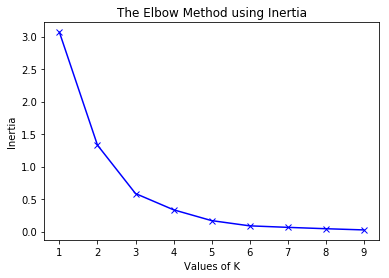

In [48]:
fig = plt.figure()
fig.figsize=(20,30)

#plt.subplot(1,2,1)
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 


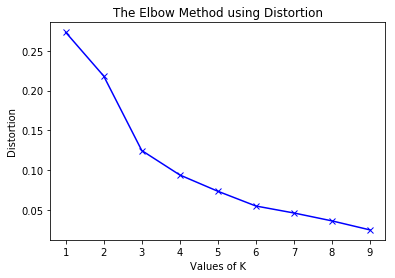

In [49]:
#plt.subplot(1,2,2)
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

From observing the above figures and considering both the inertia and distortion, we determine that the **optimal value of k would be 3.**

### Running K-means with k = 3

In [50]:
# set number of clusters
kclusters = 3

cmb_clustering = df_cmb_sorted.drop(["Neighborhood"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cmb_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 2, 2, 0, 0, 1, 2, 2, 2], dtype=int32)

In [51]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
cmb_merged = df_cmb_sorted.copy()

# add clustering labels
cmb_merged["Cluster Labels"] = kmeans.labels_

In [52]:
# merge cmb_merged with df_cmb to add latitude/longitude for each neighborhood
cmb_merged = cmb_merged.join(df_cmb.set_index("Neighborhood"), on="Neighborhood")



In [53]:
#sort the results by Cluster Labels
print(cmb_merged.shape)
cmb_merged.sort_values(["Cluster Labels"], inplace=True)
cmb_merged.drop(['Postal Code'],axis=1,inplace=True)
display(cmb_merged)


(23, 8)


,Neighborhood,Entertainment,Hotel,Restaurant,Cluster Labels,Latitude,Longitude
1,Battaramulla,0.000000,0.000000,1.000000,0,6.902181,79.919578
19,Rajagiriya,0.058824,0.000000,0.941176,0,6.909504,79.896218
4,Dehiwala,0.111111,0.000000,0.888889,0,6.851279,79.865977
5,Dematagoda,0.000000,0.000000,1.000000,0,6.936130,79.880049
10,Kolonnawa,0.000000,0.000000,1.000000,0,6.932625,79.890314
12,Maharagama,0.000000,0.000000,1.000000,0,6.847278,79.926608
14,Moratuwa,0.000000,0.000000,1.000000,0,6.774682,79.882610
6,Fort,0.500000,0.500000,0.000000,1,6.946338,79.843968
16,Mutwal,1.000000,0.000000,0.000000,1,6.962534,79.864048
0,Bambalapitiya,0.138462,0.123077,0.738462,2,6.901825,79.854683


### Creating Map using Folium with the neighbourhoods marked by cluster

In [54]:
# create map
map_clusters = folium.Map(location=[central_loc[0], central_loc[1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cmb_merged['Latitude'], cmb_merged['Longitude'], cmb_merged['Neighborhood'], cmb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining Generated Clusters

In [55]:
#Removing unneeded columns for clarity's sake
cmb_clustered=cmb_merged.drop(columns=['Latitude','Longitude'])

### Cluster 0

In [56]:
cmb_clustered.loc[cmb_clustered['Cluster Labels'] == 0]

,Neighborhood,Entertainment,Hotel,Restaurant,Cluster Labels
1,Battaramulla,0.000000,0.0,1.000000,0
19,Rajagiriya,0.058824,0.0,0.941176,0
4,Dehiwala,0.111111,0.0,0.888889,0
5,Dematagoda,0.000000,0.0,1.000000,0
10,Kolonnawa,0.000000,0.0,1.000000,0
12,Maharagama,0.000000,0.0,1.000000,0
14,Moratuwa,0.000000,0.0,1.000000,0


### Cluster 1

In [57]:
cmb_clustered.loc[cmb_clustered['Cluster Labels'] == 1]

,Neighborhood,Entertainment,Hotel,Restaurant,Cluster Labels
6,Fort,0.5,0.5,0.0,1
16,Mutwal,1.0,0.0,0.0,1


### Cluster 2

In [58]:
cmb_clustered.loc[cmb_clustered['Cluster Labels'] == 2]

,Neighborhood,Entertainment,Hotel,Restaurant,Cluster Labels
0,Bambalapitiya,0.138462,0.123077,0.738462,2
20,Slave Island,0.188406,0.173913,0.637681,2
18,Pettah,0.238095,0.095238,0.666667,2
17,Narahenpita,0.285714,0.000000,0.714286,2
15,Mount Lavinia,0.176471,0.176471,0.647059,2
11,Kotahena,0.333333,0.000000,0.666667,2
21,Sri Jayawardenepura,0.222222,0.000000,0.777778,2
9,Kollupitiya,0.260870,0.086957,0.652174,2
8,Hulftsdorp,0.125000,0.125000,0.750000,2
7,Grandpass,0.500000,0.000000,0.500000,2


## Analysis of Clusters

In the neighbourhoods in Cluster 0, we see that the their are little to no hotels or entertainment venues, compared to the number of restaurants in the area. Therefore it would not be advisable to locate a new restaurant there. Although it may be interesting to find out why there is such a high concentration of restaurants there in the first place, but that is a problem for another time.

As for Cluster 1, this should be an ideal place for a restaurant since there are hotels and entertainment areas, but no restaurants. However upon closer inspection, we find that these areas have only a single hotel and an entertainment venue, and just a single hotel respectively. Thus these areas would not be suitable either.

Then we come to Cluster 2. While this area too has a high proportion of restaurants to other venues, it still has a decent amount of hotels and entertainment venues. Thus if we were to start a restaurant, it should be within these neighbourhoods.

___
## Thank you for reading
___